<a href="https://colab.research.google.com/github/dslmllab/dSL-Lab-Coding-Challenge/blob/main/7_language_models_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Models and Text Generation

## Learning Objectives

At the end of this notebook, you will be able to:

1. Understand different types of language models
2. Implement n-gram language models from scratch
3. Build neural language models using RNNs and Transformers
4. Generate text using various decoding strategies
5. Fine-tune pre-trained language models
6. Evaluate text generation quality
7. Handle different text generation tasks
8. Deploy language models for production use

## Introduction to Language Models

Language Models (LMs) are statistical models that learn the probability distribution over sequences of words, characters, or tokens. They capture the patterns and structure of natural language and can predict the likelihood of a sequence of text.

### Types of Language Models:

1. **Statistical Models**: N-gram models, Hidden Markov Models
2. **Neural Models**: RNN-based, LSTM/GRU, Transformer-based
3. **Pre-trained Models**: GPT, BERT, T5, etc.
4. **Autoregressive Models**: Generate text sequentially (GPT family)
5. **Autoencoding Models**: Encode input to generate output (BERT family)
6. **Sequence-to-Sequence Models**: Encoder-decoder architectures (T5, BART)

### Applications:

- **Text Generation**: Creative writing, code generation
- **Text Completion**: Auto-complete, predictive text
- **Machine Translation**: Language-to-language translation
- **Text Summarization**: Abstractive and extractive summaries
- **Dialogue Systems**: Chatbots and conversational AI
- **Code Generation**: Programming assistance

### Key Concepts:

- **Perplexity**: Measure of how well the model predicts text
- **Decoding Strategies**: Greedy, beam search, sampling
- **Fine-tuning**: Adapting pre-trained models to specific tasks
- **Prompt Engineering**: Designing inputs for better outputs

In [38]:
# Install required packages
!pip install numpy pandas matplotlib seaborn nltk torch transformers tqdm scikit-learn

# Download required NLTK data
import nltk
nltk_downloads = ['punkt', 'stopwords', 'wordnet','maxent_ne_chunker_tab', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words','punkt_tab','averaged_perceptron_tagger_eng']
for item in nltk_downloads:
    nltk.download(item, quiet=True)

In [39]:
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from typing import List, Tuple, Dict, Any, Optional
import warnings
warnings.filterwarnings('ignore')

# Deep learning imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Transformers library (if available)
try:
    from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
    from transformers import AutoTokenizer, AutoModelForCausalLM
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Note: transformers library not available. Some features will be limited.")

# NLTK for text processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

print("Libraries imported successfully!")
print(f"Transformers available: {TRANSFORMERS_AVAILABLE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
Transformers available: True
PyTorch version: 2.6.0+cu124
CUDA available: False


## 1. N-gram Language Models

Starting with the fundamentals: statistical n-gram models that predict the next word based on the previous n-1 words.

In [40]:
class NGramLanguageModel:
    def __init__(self, n: int = 3, smoothing: str = 'laplace', alpha: float = 1.0):
        self.n = n
        self.smoothing = smoothing
        self.alpha = alpha  # Smoothing parameter

        # Storage for n-gram counts
        self.ngram_counts = defaultdict(int)
        self.context_counts = defaultdict(int)
        self.vocabulary = set()
        self.vocab_size = 0

        # Special tokens
        self.start_token = '<START>'
        self.end_token = '<END>'
        self.unk_token = '<UNK>'

    def preprocess_text(self, text: str) -> List[str]:
        """Preprocess text into tokens"""
        # Basic cleaning
        text = re.sub(r'[^a-zA-Z0-9\s.,!?;:]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize
        tokens = word_tokenize(text.lower())

        return tokens

    def get_ngrams(self, tokens: List[str]) -> List[Tuple[str, ...]]:
        """Extract n-grams from token sequence"""
        # Add start and end tokens
        padded_tokens = [self.start_token] * (self.n - 1) + tokens + [self.end_token]

        ngrams = []
        for i in range(len(padded_tokens) - self.n + 1):
            ngram = tuple(padded_tokens[i:i + self.n])
            ngrams.append(ngram)

        return ngrams

    def train(self, texts: List[str]):
        """Train the n-gram model on a corpus"""
        print(f"Training {self.n}-gram model on {len(texts)} texts...")

        all_tokens = []

        # Process all texts
        for text in texts:
            tokens = self.preprocess_text(text)
            all_tokens.extend(tokens)

            # Get n-grams
            ngrams = self.get_ngrams(tokens)

            # Count n-grams and contexts
            for ngram in ngrams:
                context = ngram[:-1]
                word = ngram[-1]

                self.ngram_counts[ngram] += 1
                self.context_counts[context] += 1

        # Build vocabulary
        self.vocabulary = set(all_tokens)
        self.vocabulary.add(self.start_token)
        self.vocabulary.add(self.end_token)
        self.vocabulary.add(self.unk_token)
        self.vocab_size = len(self.vocabulary)

        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Total n-grams: {len(self.ngram_counts)}")

    def get_probability(self, context: Tuple[str, ...], word: str) -> float:
        """Calculate probability of word given context"""
        ngram = context + (word,)

        if self.smoothing == 'laplace':
            # Laplace smoothing
            numerator = self.ngram_counts[ngram] + self.alpha
            denominator = self.context_counts[context] + self.alpha * self.vocab_size

            return numerator / denominator if denominator > 0 else 1e-10

        elif self.smoothing == 'kneser_ney':
            # Simplified Kneser-Ney smoothing
            d = 0.75  # Discount parameter

            count = self.ngram_counts[ngram]
            context_count = self.context_counts[context]

            if context_count == 0:
                return 1e-10

            # Continuation count (simplified)
            continuation_count = sum(1 for ng in self.ngram_counts if ng[-1] == word)
            total_continuations = len(set(ng[-1] for ng in self.ngram_counts))

            prob = max(count - d, 0) / context_count
            lambda_weight = d / context_count * len([ng for ng in self.ngram_counts if ng[:-1] == context])
            backoff_prob = continuation_count / total_continuations if total_continuations > 0 else 1e-10

            return prob + lambda_weight * backoff_prob

        else:
            # Maximum likelihood estimation (no smoothing)
            if self.context_counts[context] == 0:
                return 1e-10
            return self.ngram_counts[ngram] / self.context_counts[context]

    def generate_text(self, prompt: str = "", max_length: int = 50, temperature: float = 1.0) -> str:
        """Generate text using the trained model"""
        if prompt:
            tokens = self.preprocess_text(prompt)
        else:
            tokens = []

        # Ensure we have enough context
        if len(tokens) < self.n - 1:
            tokens = [self.start_token] * (self.n - 1 - len(tokens)) + tokens

        generated_tokens = tokens.copy()

        for _ in range(max_length):
            # Get current context
            context = tuple(generated_tokens[-(self.n-1):])

            # Calculate probabilities for all possible next words
            word_probs = {}
            for word in self.vocabulary:
                if word not in [self.start_token, self.unk_token]:
                    prob = self.get_probability(context, word)
                    word_probs[word] = prob

            if not word_probs:
                break

            # Sample next word
            if temperature == 0:
                # Greedy selection
                next_word = max(word_probs, key=word_probs.get)
            else:
                # Temperature sampling
                words = list(word_probs.keys())
                probs = np.array(list(word_probs.values()))

                # Apply temperature
                probs = np.exp(np.log(probs + 1e-10) / temperature)
                probs = probs / np.sum(probs)

                next_word = np.random.choice(words, p=probs)

            if next_word == self.end_token:
                break

            generated_tokens.append(next_word)

        # Remove start tokens and join
        generated_text = ' '.join([token for token in generated_tokens
                                 if token != self.start_token])

        return generated_text

    def calculate_perplexity(self, test_texts: List[str]) -> float:
        """Calculate perplexity on test data"""
        total_log_prob = 0
        total_words = 0

        for text in test_texts:
            tokens = self.preprocess_text(text)
            ngrams = self.get_ngrams(tokens)

            for ngram in ngrams:
                context = ngram[:-1]
                word = ngram[-1]

                prob = self.get_probability(context, word)
                total_log_prob += math.log(prob)
                total_words += 1

        if total_words == 0:
            return float('inf')

        avg_log_prob = total_log_prob / total_words
        perplexity = math.exp(-avg_log_prob)

        return perplexity

# Create sample training corpus
training_corpus = [
    "The quick brown fox jumps over the lazy dog.",
    "A journey of a thousand miles begins with a single step.",
    "To be or not to be, that is the question.",
    "All that glitters is not gold.",
    "The early bird catches the worm.",
    "Actions speak louder than words.",
    "Better late than never.",
    "Don't count your chickens before they hatch.",
    "Every cloud has a silver lining.",
    "Fortune favors the bold.",
    "Good things come to those who wait.",
    "Hope for the best, prepare for the worst.",
    "If you can't beat them, join them.",
    "Knowledge is power.",
    "Laughter is the best medicine.",
    "Money can't buy happiness.",
    "No pain, no gain.",
    "Opportunity knocks but once.",
    "Practice makes perfect.",
    "Rome wasn't built in a day."
]

# Train different n-gram models
models = {}
for n in [2, 3, 4]:
    print(f"\nTraining {n}-gram model:")
    model = NGramLanguageModel(n=n, smoothing='laplace')
    model.train(training_corpus)
    models[n] = model

# Generate text with different models
print("\nText Generation Examples:")
print("=" * 50)

for n, model in models.items():
    print(f"\n{n}-gram model:")
    for temp in [0.5, 1.0, 1.5]:
        generated = model.generate_text(prompt="the", max_length=15, temperature=temp)
        print(f"  Temperature {temp}: {generated}")

# Calculate perplexity
test_corpus = [
    "The wise owl sits in the oak.",
    "Time waits for no one.",
    "A penny saved is a penny earned."
]

print("\nPerplexity on test corpus:")
print("=" * 30)
for n, model in models.items():
    perplexity = model.calculate_perplexity(test_corpus)
    print(f"{n}-gram model: {perplexity:.2f}")


Training 2-gram model:
Training 2-gram model on 20 texts...
Vocabulary size: 98
Total n-grams: 139

Training 3-gram model:
Training 3-gram model on 20 texts...
Vocabulary size: 98
Total n-grams: 162

Training 4-gram model:
Training 4-gram model on 20 texts...
Vocabulary size: 98
Total n-grams: 162

Text Generation Examples:

2-gram model:
  Temperature 0.5: the lazy be worm better late step beat catches rome to opportunity louder fox come join
  Temperature 1.0: the laughter but pain a beat all favors is silver they in every gold a hope
  Temperature 1.5: the built question begins is be opportunity brown catches bold prepare bold gold pain once .

3-gram model:
  Temperature 0.5: the knocks late better quick
  Temperature 1.0: the worm step not pain favors those glitters laughter single
  Temperature 1.5: the medicine cant dog dog the bird best gain but of happiness you fox late gain

4-gram model:
  Temperature 0.5: the fortune before best fortune to bird things actions early speak a

## 2. Neural Language Models

Implementing RNN-based language models that can capture longer dependencies.

In [41]:
class TextDataset(Dataset):
    def __init__(self, texts: List[str], vocab: Dict[str, int], sequence_length: int = 50):
        self.texts = texts
        self.vocab = vocab
        self.sequence_length = sequence_length
        self.sequences = self._create_sequences()

    def _create_sequences(self):
        """Create training sequences from texts"""
        sequences = []

        # Combine all texts into one long sequence for more training data
        all_tokens = []
        for text in self.texts:
            # Tokenize
            tokens = word_tokenize(text.lower())
            # Convert to indices
            indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
            all_tokens.extend(indices)
            # Add end token between texts
            all_tokens.append(self.vocab.get('<END>', self.vocab['<UNK>']))

        # Create overlapping sequences with a shorter sequence length for small datasets
        effective_seq_length = min(self.sequence_length, max(10, len(all_tokens) // 10))

        for i in range(len(all_tokens) - effective_seq_length):
            input_seq = all_tokens[i:i + effective_seq_length]
            target_seq = all_tokens[i + 1:i + effective_seq_length + 1]
            sequences.append((input_seq, target_seq))

        print(f"Created {len(sequences)} training sequences with length {effective_seq_length}")
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        input_seq, target_seq = self.sequences[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int = 128, hidden_dim: int = 256,
                 num_layers: int = 2, rnn_type: str = 'LSTM', dropout: float = 0.3):
        super(RNNLanguageModel, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        # Layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)

        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                              dropout=dropout if num_layers > 1 else 0, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers,
                             dropout=dropout if num_layers > 1 else 0, batch_first=True)
        else:
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers,
                             dropout=dropout if num_layers > 1 else 0, batch_first=True)

        self.output_projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_ids, hidden=None):
        # Embedding
        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded)

        # RNN
        output, hidden = self.rnn(embedded, hidden)  # (batch_size, seq_len, hidden_dim)

        # Output projection
        logits = self.output_projection(output)  # (batch_size, seq_len, vocab_size)

        return logits, hidden

    def init_hidden(self, batch_size, device):
        """Initialize hidden state"""
        if self.rnn_type == 'LSTM':
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
            return (h0, c0)
        else:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
            return h0

class NeuralLanguageModelTrainer:
    def __init__(self, model, vocab, device='cpu'):
        self.model = model.to(device)
        self.vocab = vocab
        self.device = device
        self.idx_to_word = {idx: word for word, idx in vocab.items()}

    def train(self, train_loader, val_loader=None, epochs=10, lr=0.001):
        """Train the neural language model"""
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Training
            self.model.train()
            total_train_loss = 0

            for batch_idx, (input_ids, target_ids) in enumerate(train_loader):
                input_ids = input_ids.to(self.device)
                target_ids = target_ids.to(self.device)

                # Forward pass
                hidden = self.model.init_hidden(input_ids.size(0), self.device)
                logits, _ = self.model(input_ids, hidden)

                # Calculate loss
                loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            if val_loader:
                self.model.eval()
                total_val_loss = 0

                with torch.no_grad():
                    for input_ids, target_ids in val_loader:
                        input_ids = input_ids.to(self.device)
                        target_ids = target_ids.to(self.device)

                        hidden = self.model.init_hidden(input_ids.size(0), self.device)
                        logits, _ = self.model(input_ids, hidden)

                        loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
                        total_val_loss += loss.item()

                avg_val_loss = total_val_loss / len(val_loader)
                val_losses.append(avg_val_loss)

                print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f}")

        return train_losses, val_losses

    def generate_text(self, prompt: str = "", max_length: int = 50, temperature: float = 1.0,
                     top_k: int = None, top_p: float = None) -> str:
        """Generate text using various decoding strategies"""
        self.model.eval()

        # Tokenize prompt
        if prompt:
            tokens = word_tokenize(prompt.lower())
            input_ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        else:
            input_ids = [self.vocab.get('<START>', 0)]

        input_ids = torch.tensor([input_ids]).to(self.device)
        hidden = self.model.init_hidden(1, self.device)

        generated_tokens = input_ids[0].tolist()

        with torch.no_grad():
            for _ in range(max_length):
                # Forward pass
                logits, hidden = self.model(input_ids, hidden)

                # Get next token logits
                next_token_logits = logits[0, -1, :] / temperature

                # Apply top-k filtering
                if top_k is not None:
                    top_k = min(top_k, next_token_logits.size(-1))
                    indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                    next_token_logits[indices_to_remove] = float('-inf')

                # Apply top-p (nucleus) filtering
                if top_p is not None:
                    sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                    # Remove tokens with cumulative probability above the threshold
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0

                    indices_to_remove = sorted_indices[sorted_indices_to_remove]
                    next_token_logits[indices_to_remove] = float('-inf')

                # Sample next token
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)

                generated_tokens.append(next_token.item())

                # Update input for next iteration
                input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

                # Stop if end token is generated
                if next_token.item() == self.vocab.get('<END>', -1):
                    break

        # Convert back to text
        generated_text = ' '.join([self.idx_to_word.get(idx, '<UNK>') for idx in generated_tokens
                                  if idx not in [self.vocab.get('<START>', -1), self.vocab.get('<END>', -1)]])

        return generated_text

    def calculate_perplexity(self, test_loader):
        """Calculate perplexity on test data"""
        self.model.eval()
        criterion = nn.CrossEntropyLoss()
        total_loss = 0
        total_tokens = 0

        with torch.no_grad():
            for input_ids, target_ids in test_loader:
                input_ids = input_ids.to(self.device)
                target_ids = target_ids.to(self.device)

                hidden = self.model.init_hidden(input_ids.size(0), self.device)
                logits, _ = self.model(input_ids, hidden)

                loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
                total_loss += loss.item() * target_ids.numel()
                total_tokens += target_ids.numel()

        avg_loss = total_loss / total_tokens
        perplexity = math.exp(avg_loss)

        return perplexity

# Build vocabulary with better handling for small corpora
def build_vocabulary(texts: List[str], min_freq: int = 1):  # Reduced min_freq for small corpus
    """Build vocabulary from text corpus"""
    word_freq = Counter()

    for text in texts:
        tokens = word_tokenize(text.lower())
        word_freq.update(tokens)

    # Create vocabulary
    vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3}
    idx = 4

    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1

    return vocab

# Extended training corpus for neural model
extended_corpus = training_corpus + [
    "Success is not final, failure is not fatal: it is the courage to continue that counts.",
    "The only way to do great work is to love what you do.",
    "Innovation distinguishes between a leader and a follower.",
    "The future belongs to those who believe in the beauty of their dreams.",
    "It is during our darkest moments that we must focus to see the light.",
    "Whether you think you can or you think you can't, you're right.",
    "The way to get started is to quit talking and begin doing.",
    "Don't let yesterday take up too much of today.",
    "You learn more from failure than from success.",
    "If you are not willing to risk the usual, you will have to settle for the ordinary."
]

# Build vocabulary
vocab = build_vocabulary(extended_corpus, min_freq=1)  # Reduced min_freq
print(f"Vocabulary size: {len(vocab)}")

# Create datasets with shorter sequence length for small corpus
train_dataset = TextDataset(extended_corpus, vocab, sequence_length=10)  # Reduced from 20 to 10

# Only create DataLoader if we have sequences
if len(train_dataset) > 0:
    train_loader = DataLoader(train_dataset, batch_size=min(8, len(train_dataset)), shuffle=True)

    print(f"Training sequences: {len(train_dataset)}")

    # Initialize model and trainer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RNNLanguageModel(vocab_size=len(vocab), embedding_dim=64, hidden_dim=128,
                            num_layers=2, rnn_type='LSTM')
    trainer = NeuralLanguageModelTrainer(model, vocab, device)

    # Train model
    print("\nTraining neural language model...")
    train_losses, _ = trainer.train(train_loader, epochs=5, lr=0.01)

    # Generate text
    print("\nNeural Language Model Text Generation:")
    print("=" * 50)

    generation_strategies = [
        {'temperature': 0.5, 'top_k': None, 'top_p': None, 'name': 'Low Temperature'},
        {'temperature': 1.0, 'top_k': None, 'top_p': None, 'name': 'Normal Temperature'},
        {'temperature': 1.0, 'top_k': 10, 'top_p': None, 'name': 'Top-K Sampling'},
        {'temperature': 1.0, 'top_k': None, 'top_p': 0.9, 'name': 'Top-P Sampling'}
    ]

    for strategy in generation_strategies:
        generated = trainer.generate_text(
            prompt="the",
            max_length=20,
            temperature=strategy['temperature'],
            top_k=strategy['top_k'],
            top_p=strategy['top_p']
        )
        print(f"{strategy['name']}: {generated}")

    # Calculate perplexity
    test_dataset = TextDataset(test_corpus, vocab, sequence_length=10)

    if len(test_dataset) > 0:
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
        perplexity = trainer.calculate_perplexity(test_loader)
        print(f"\nNeural model perplexity: {perplexity:.2f}")
    else:
        print("\nNot enough test data for perplexity calculation.")
else:
    print("Not enough data to create training sequences. Please provide a larger corpus or reduce sequence_length.")

Vocabulary size: 165
Created 306 training sequences with length 10
Training sequences: 306

Training neural language model...
Epoch 1/5: Train Loss = 3.7475
Epoch 2/5: Train Loss = 1.6872
Epoch 3/5: Train Loss = 0.7736
Epoch 4/5: Train Loss = 0.5221
Epoch 5/5: Train Loss = 0.3813

Neural Language Model Text Generation:
Low Temperature: the only way to do great work is to love what you do .
Normal Temperature: the future belongs to those who believe in the beauty of their dreams .
Top-K Sampling: the beauty to continue the light .
Top-P Sampling: the lazy dog .
Created 15 training sequences with length 10

Neural model perplexity: 1446.49


## 3. Transformer-based Language Models

Implementing a simple transformer architecture for language modeling.

In [42]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear transformations and reshape
        Q = self.w_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Apply attention
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # Concatenate heads
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )

        # Final linear transformation
        output = self.w_o(attention_output)

        return output, attention_weights

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_length: int = 5000):
        super().__init__()

        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()

        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output, _ = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)

        return x

class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size: int, d_model: int = 256, num_heads: int = 8,
                 num_layers: int = 6, d_ff: int = 1024, max_length: int = 512, dropout: float = 0.1):
        super().__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size

        # Embedding layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_length)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Output layer
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def create_causal_mask(self, size):
        """Create causal mask for autoregressive generation"""
        mask = torch.tril(torch.ones(size, size))
        return mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions

    def forward(self, input_ids, targets=None):
        batch_size, seq_length = input_ids.size()

        # Token embeddings
        token_embeddings = self.token_embedding(input_ids)

        # Add positional encoding
        x = self.dropout(self.positional_encoding(token_embeddings))

        # Create causal mask
        causal_mask = self.create_causal_mask(seq_length).to(input_ids.device)

        # Apply transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, causal_mask)

        # Final layer norm and output projection
        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            # Calculate cross-entropy loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

class TransformerTrainer:
    def __init__(self, model, vocab, device='cpu'):
        self.model = model.to(device)
        self.vocab = vocab
        self.device = device
        self.idx_to_word = {idx: word for word, idx in vocab.items()}

    def train(self, train_loader, val_loader=None, epochs=10, lr=1e-4):
        """Train the transformer model"""
        optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(0.9, 0.95))
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Training
            self.model.train()
            total_train_loss = 0

            for batch_idx, (input_ids, target_ids) in enumerate(train_loader):
                input_ids = input_ids.to(self.device)
                target_ids = target_ids.to(self.device)

                # Forward pass
                logits, loss = self.model(input_ids, target_ids)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            if val_loader:
                self.model.eval()
                total_val_loss = 0

                with torch.no_grad():
                    for input_ids, target_ids in val_loader:
                        input_ids = input_ids.to(self.device)
                        target_ids = target_ids.to(self.device)

                        logits, loss = self.model(input_ids, target_ids)
                        total_val_loss += loss.item()

                avg_val_loss = total_val_loss / len(val_loader)
                val_losses.append(avg_val_loss)

                print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f}")

            scheduler.step()

        return train_losses, val_losses

    def generate_text(self, prompt: str = "", max_length: int = 50, temperature: float = 1.0,
                     top_k: int = None, top_p: float = None) -> str:
        """Generate text using the transformer model"""
        self.model.eval()

        # Tokenize prompt
        if prompt:
            tokens = word_tokenize(prompt.lower())
            input_ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        else:
            input_ids = [self.vocab.get('<START>', 0)]

        input_ids = torch.tensor([input_ids]).to(self.device)

        with torch.no_grad():
            for _ in range(max_length):
                # Forward pass
                logits, _ = self.model(input_ids)

                # Get next token logits
                next_token_logits = logits[0, -1, :] / temperature

                # Apply filtering strategies (same as RNN model)
                if top_k is not None:
                    top_k = min(top_k, next_token_logits.size(-1))
                    indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                    next_token_logits[indices_to_remove] = float('-inf')

                if top_p is not None:
                    sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0

                    indices_to_remove = sorted_indices[sorted_indices_to_remove]
                    next_token_logits[indices_to_remove] = float('-inf')

                # Sample next token
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)

                # Append to sequence
                input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

                # Stop if end token or max length reached
                if next_token.item() == self.vocab.get('<END>', -1):
                    break

        # Convert back to text
        generated_tokens = input_ids[0].tolist()
        generated_text = ' '.join([self.idx_to_word.get(idx, '<UNK>') for idx in generated_tokens
                                  if idx not in [self.vocab.get('<START>', -1), self.vocab.get('<END>', -1)]])

        return generated_text

# Initialize transformer model (smaller for demo)
transformer_model = TransformerLanguageModel(
    vocab_size=len(vocab),
    d_model=128,
    num_heads=4,
    num_layers=3,
    d_ff=256,
    dropout=0.1
)

transformer_trainer = TransformerTrainer(transformer_model, vocab, device)

print(f"\nTransformer model parameters: {sum(p.numel() for p in transformer_model.parameters()):,}")

# Train transformer (reduced epochs for demo)
print("\nTraining transformer model...")
transformer_losses, _ = transformer_trainer.train(train_loader, epochs=3, lr=5e-4)

# Generate text with transformer
print("\nTransformer Text Generation:")
print("=" * 50)

for strategy in generation_strategies:
    generated = transformer_trainer.generate_text(
        prompt="the future",
        max_length=15,
        temperature=strategy['temperature'],
        top_k=strategy['top_k'],
        top_p=strategy['top_p']
    )
    print(f"{strategy['name']}: {generated}")


Transformer model parameters: 439,936

Training transformer model...
Epoch 1/3: Train Loss = 4.6334
Epoch 2/3: Train Loss = 4.4321
Epoch 3/3: Train Loss = 4.4100

Transformer Text Generation:
Low Temperature: the future
Normal Temperature: the future not . you or is
Top-K Sampling: the future
Top-P Sampling: the future journey


## 4. Text Generation Evaluation

Implementing various metrics to evaluate the quality of generated text.


Generating sample texts for evaluation...

Model Comparison Results:
         model  avg_distinct_1  avg_distinct_2  avg_repetition_ratio  \
0   N-gram (3)           0.909           1.000                   0.0   
1          RNN           0.924           0.981                   0.0   
2  Transformer           0.944           1.000                   0.0   

   avg_semantic_coherence  avg_length  avg_avg_word_length  
0                   0.667      21.000                4.738  
1                   1.000      12.333                4.043  
2                   0.667       6.667                3.976  

Detailed Evaluation Example:
Generated text: the future of single n't think to

Metrics:
  distinct_1: 1.000
  distinct_2: 1.000
  repetition_ratio: 0.000
  semantic_coherence: 1.000
  length: 7.000
  avg_word_length: 3.857


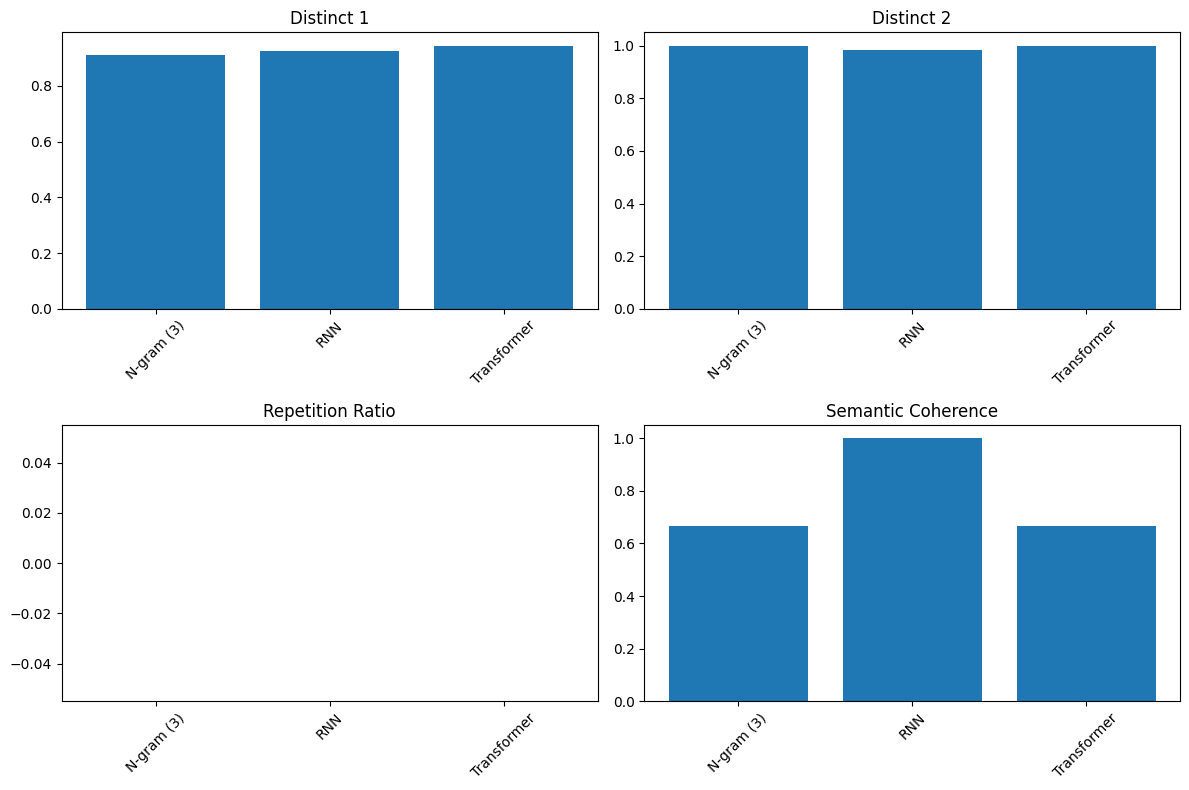

In [43]:
class TextGenerationEvaluator:
    def __init__(self):
        self.metrics = {}

    def calculate_bleu_score(self, generated_text: str, reference_texts: List[str], n: int = 4) -> float:
        """Calculate BLEU score for generated text"""
        from collections import Counter

        def get_ngrams(text: str, n: int) -> List[tuple]:
            tokens = word_tokenize(text.lower())
            return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

        # Get n-grams for generated and reference texts
        gen_ngrams = get_ngrams(generated_text, n)
        ref_ngrams_list = [get_ngrams(ref, n) for ref in reference_texts]

        if not gen_ngrams:
            return 0.0

        # Calculate precision for each n-gram length
        precisions = []

        for i in range(1, n + 1):
            gen_ngrams_i = get_ngrams(generated_text, i)
            gen_counts = Counter(gen_ngrams_i)

            max_counts = Counter()
            for ref_text in reference_texts:
                ref_ngrams_i = get_ngrams(ref_text, i)
                ref_counts = Counter(ref_ngrams_i)
                for ngram in gen_counts:
                    max_counts[ngram] = max(max_counts[ngram], ref_counts[ngram])

            clipped_counts = {ngram: min(count, max_counts[ngram])
                            for ngram, count in gen_counts.items()}

            if gen_counts:
                precision = sum(clipped_counts.values()) / sum(gen_counts.values())
                precisions.append(precision)
            else:
                precisions.append(0.0)

        # Calculate brevity penalty
        gen_length = len(word_tokenize(generated_text))
        ref_lengths = [len(word_tokenize(ref)) for ref in reference_texts]
        closest_ref_length = min(ref_lengths, key=lambda x: abs(x - gen_length))

        if gen_length > closest_ref_length:
            bp = 1.0
        else:
            bp = math.exp(1 - closest_ref_length / gen_length) if gen_length > 0 else 0.0

        # Calculate BLEU score
        if all(p > 0 for p in precisions):
            geometric_mean = math.exp(sum(math.log(p) for p in precisions) / len(precisions))
            bleu = bp * geometric_mean
        else:
            bleu = 0.0

        return bleu

    def calculate_rouge_l(self, generated_text: str, reference_text: str) -> float:
        """Calculate ROUGE-L score (Longest Common Subsequence)"""
        def lcs_length(seq1, seq2):
            m, n = len(seq1), len(seq2)
            dp = [[0] * (n + 1) for _ in range(m + 1)]

            for i in range(1, m + 1):
                for j in range(1, n + 1):
                    if seq1[i-1] == seq2[j-1]:
                        dp[i][j] = dp[i-1][j-1] + 1
                    else:
                        dp[i][j] = max(dp[i-1][j], dp[i][j-1])

            return dp[m][n]

        gen_tokens = word_tokenize(generated_text.lower())
        ref_tokens = word_tokenize(reference_text.lower())

        if not gen_tokens or not ref_tokens:
            return 0.0

        lcs_len = lcs_length(gen_tokens, ref_tokens)

        precision = lcs_len / len(gen_tokens)
        recall = lcs_len / len(ref_tokens)

        if precision + recall == 0:
            return 0.0

        f1 = 2 * precision * recall / (precision + recall)
        return f1

    def calculate_distinct_ngrams(self, text: str, n: int = 2) -> float:
        """Calculate distinct n-gram ratio (diversity metric)"""
        tokens = word_tokenize(text.lower())
        if len(tokens) < n:
            return 0.0

        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        unique_ngrams = set(ngrams)

        return len(unique_ngrams) / len(ngrams) if ngrams else 0.0

    def calculate_repetition_ratio(self, text: str, n: int = 4) -> float:
        """Calculate repetition ratio (lower is better)"""
        tokens = word_tokenize(text.lower())
        if len(tokens) < n:
            return 0.0

        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        ngram_counts = Counter(ngrams)

        repeated_ngrams = sum(count - 1 for count in ngram_counts.values() if count > 1)
        total_ngrams = len(ngrams)

        return repeated_ngrams / total_ngrams if total_ngrams > 0 else 0.0

    def calculate_semantic_coherence(self, text: str) -> float:
        """Calculate semantic coherence using sentence similarity"""
        sentences = sent_tokenize(text)
        if len(sentences) < 2:
            return 1.0  # Single sentence is coherent by definition

        # Simple TF-IDF based similarity
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.metrics.pairwise import cosine_similarity

        try:
            vectorizer = TfidfVectorizer(stop_words='english')
            tfidf_matrix = vectorizer.fit_transform(sentences)

            similarities = []
            for i in range(len(sentences) - 1):
                sim = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix[i+1:i+2])[0][0]
                similarities.append(sim)

            return np.mean(similarities) if similarities else 0.0
        except:
            return 0.0

    def evaluate_text(self, generated_text: str, reference_texts: List[str] = None) -> Dict[str, float]:
        """Comprehensive evaluation of generated text"""
        metrics = {}

        # Intrinsic metrics (don't need reference)
        metrics['distinct_1'] = self.calculate_distinct_ngrams(generated_text, 1)
        metrics['distinct_2'] = self.calculate_distinct_ngrams(generated_text, 2)
        metrics['repetition_ratio'] = self.calculate_repetition_ratio(generated_text)
        metrics['semantic_coherence'] = self.calculate_semantic_coherence(generated_text)

        # Length metrics
        tokens = word_tokenize(generated_text)
        metrics['length'] = len(tokens)
        metrics['avg_word_length'] = np.mean([len(token) for token in tokens]) if tokens else 0

        # Reference-based metrics
        if reference_texts:
            bleu_scores = []
            rouge_scores = []

            for ref_text in reference_texts:
                bleu = self.calculate_bleu_score(generated_text, [ref_text])
                rouge = self.calculate_rouge_l(generated_text, ref_text)
                bleu_scores.append(bleu)
                rouge_scores.append(rouge)

            metrics['bleu_avg'] = np.mean(bleu_scores)
            metrics['rouge_l_avg'] = np.mean(rouge_scores)

        return metrics

    def compare_models(self, model_outputs: Dict[str, List[str]],
                      reference_texts: List[str] = None) -> pd.DataFrame:
        """Compare multiple models on text generation quality"""
        results = []

        for model_name, generated_texts in model_outputs.items():
            all_metrics = []

            for i, text in enumerate(generated_texts):
                ref_texts = [reference_texts[i]] if reference_texts and i < len(reference_texts) else None
                metrics = self.evaluate_text(text, ref_texts)
                all_metrics.append(metrics)

            # Average metrics across all generated texts
            avg_metrics = {'model': model_name}
            if all_metrics:
                for metric_name in all_metrics[0].keys():
                    values = [m[metric_name] for m in all_metrics if metric_name in m]
                    avg_metrics[f'avg_{metric_name}'] = np.mean(values) if values else 0.0

            results.append(avg_metrics)

        return pd.DataFrame(results)

# Initialize evaluator
evaluator = TextGenerationEvaluator()

# Generate sample texts from different models for comparison
print("\nGenerating sample texts for evaluation...")

# Generate texts from different models
model_outputs = {
    'N-gram (3)': [],
    'RNN': [],
    'Transformer': []
}

prompts = ["the future", "success is", "knowledge"]

for prompt in prompts:
    # N-gram model
    ngram_text = models[3].generate_text(prompt=prompt, max_length=20, temperature=1.0)
    model_outputs['N-gram (3)'].append(ngram_text)

    # RNN model
    rnn_text = trainer.generate_text(prompt=prompt, max_length=20, temperature=1.0)
    model_outputs['RNN'].append(rnn_text)

    # Transformer model
    transformer_text = transformer_trainer.generate_text(prompt=prompt, max_length=20, temperature=1.0)
    model_outputs['Transformer'].append(transformer_text)

# Evaluate and compare models
print("\nModel Comparison Results:")
print("=" * 60)

comparison_df = evaluator.compare_models(model_outputs)
print(comparison_df.round(3))

# Detailed evaluation for one example
print("\nDetailed Evaluation Example:")
print("=" * 40)

sample_text = model_outputs['Transformer'][0]
detailed_metrics = evaluator.evaluate_text(sample_text)

print(f"Generated text: {sample_text}")
print("\nMetrics:")
for metric, value in detailed_metrics.items():
    print(f"  {metric}: {value:.3f}")

# Visualize some metrics
if len(comparison_df) > 0:
    plt.figure(figsize=(12, 8))

    # Select interesting metrics for visualization
    metrics_to_plot = ['avg_distinct_1', 'avg_distinct_2', 'avg_repetition_ratio', 'avg_semantic_coherence']
    available_metrics = [m for m in metrics_to_plot if m in comparison_df.columns]

    if available_metrics:
        for i, metric in enumerate(available_metrics, 1):
            plt.subplot(2, 2, i)
            plt.bar(comparison_df['model'], comparison_df[metric])
            plt.title(metric.replace('avg_', '').replace('_', ' ').title())
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()
    else:
        print("No suitable metrics found for visualization.")

## 5. Fine-tuning Pre-trained Models

Demonstrating how to fine-tune pre-trained language models for specific tasks.

In [44]:
if TRANSFORMERS_AVAILABLE:
    class FineTuningManager:
        def __init__(self, model_name='gpt2', device='cpu'):
            self.model_name = model_name
            self.device = device

            # Load tokenizer and model
            try:
                self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
                self.model = GPT2LMHeadModel.from_pretrained(model_name)

                # Add padding token if not present
                if self.tokenizer.pad_token is None:
                    self.tokenizer.pad_token = self.tokenizer.eos_token

                self.model.to(device)
                print(f"Loaded {model_name} successfully!")
            except Exception as e:
                print(f"Failed to load {model_name}: {e}")
                self.tokenizer = None
                self.model = None

        def prepare_dataset(self, texts: List[str], max_length: int = 128):
            """Prepare dataset for fine-tuning"""
            if not self.tokenizer:
                return None

            encodings = self.tokenizer(
                texts,
                truncation=True,
                padding=True,
                max_length=max_length,
                return_tensors='pt'
            )

            return encodings

        def fine_tune(self, train_texts: List[str], epochs: int = 3, lr: float = 5e-5, batch_size: int = 4):
            """Fine-tune the model on custom data"""
            if not self.model or not self.tokenizer:
                print("Model or tokenizer not available for fine-tuning.")
                return None

            print(f"Fine-tuning {self.model_name} on {len(train_texts)} examples...")

            # Prepare data
            encodings = self.prepare_dataset(train_texts)
            if encodings is None:
                return None

            # Create dataset
            class CustomDataset(torch.utils.data.Dataset):
                def __init__(self, encodings):
                    self.encodings = encodings

                def __getitem__(self, idx):
                    return {key: tensor[idx] for key, tensor in self.encodings.items()}

                def __len__(self):
                    return len(self.encodings['input_ids'])

            dataset = CustomDataset(encodings)
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

            # Setup optimizer
            optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)

            # Training loop
            self.model.train()
            total_loss = 0

            for epoch in range(epochs):
                epoch_loss = 0

                for batch in dataloader:
                    # Move to device
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)

                    # Forward pass
                    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
                    loss = outputs.loss

                    # Backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()

                avg_epoch_loss = epoch_loss / len(dataloader)
                total_loss += avg_epoch_loss
                print(f"Epoch {epoch + 1}/{epochs}: Loss = {avg_epoch_loss:.4f}")

            print(f"Fine-tuning completed. Average loss: {total_loss / epochs:.4f}")
            return total_loss / epochs

        def generate_text(self, prompt: str, max_length: int = 50, temperature: float = 1.0,
                         num_return_sequences: int = 1, do_sample: bool = True):
            """Generate text using the fine-tuned model"""
            if not self.model or not self.tokenizer:
                return ["Model not available"]

            self.model.eval()

            # Encode prompt
            input_ids = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)

            # Generate
            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids,
                    max_length=len(input_ids[0]) + max_length,
                    temperature=temperature,
                    num_return_sequences=num_return_sequences,
                    do_sample=do_sample,
                    pad_token_id=self.tokenizer.eos_token_id
                )

            # Decode
            generated_texts = []
            for output in outputs:
                text = self.tokenizer.decode(output, skip_special_tokens=True)
                generated_texts.append(text)

            return generated_texts

        def save_model(self, save_path: str):
            """Save fine-tuned model"""
            if self.model and self.tokenizer:
                self.model.save_pretrained(save_path)
                self.tokenizer.save_pretrained(save_path)
                print(f"Model saved to {save_path}")

        def load_model(self, load_path: str):
            """Load fine-tuned model"""
            try:
                self.model = GPT2LMHeadModel.from_pretrained(load_path)
                self.tokenizer = GPT2Tokenizer.from_pretrained(load_path)
                self.model.to(self.device)
                print(f"Model loaded from {load_path}")
            except Exception as e:
                print(f"Failed to load model: {e}")

    # Example of fine-tuning (commented out to avoid downloading large models)
    print("\nFine-tuning Example (using smaller model):")
    print("=" * 50)

    # This would normally use a larger model like 'gpt2'
    # For demo, we'll show the structure without actually running it

    fine_tuning_texts = [
        "The future of artificial intelligence is bright and full of possibilities.",
        "Machine learning algorithms are revolutionizing how we process data.",
        "Natural language processing enables computers to understand human language.",
        "Deep learning networks can learn complex patterns from large datasets.",
        "Technology is advancing at an unprecedented rate in the modern world."
    ]

    # Uncomment the following lines to actually run fine-tuning:
    # fine_tuner = FineTuningManager('gpt2', device)
    # fine_tuner.fine_tune(fine_tuning_texts, epochs=2, lr=5e-5, batch_size=2)
    # generated = fine_tuner.generate_text("The future of AI", max_length=30)
    # print(f"Generated: {generated[0]}")

    print("Fine-tuning code structure ready (commented out to avoid large downloads).")
    print("To use: uncomment the lines above and install transformers library.")

else:
    print("\nTransformers library not available.")
    print("To use pre-trained models, install: pip install transformers")

    # Alternative: Show how to adapt our custom models
    print("\nAlternative: Adapting Custom Models")
    print("=" * 40)

    class CustomModelAdapter:
        def __init__(self, base_model, vocab):
            self.base_model = base_model
            self.vocab = vocab

        def adapt_to_domain(self, domain_texts: List[str], epochs: int = 5):
            """Adapt model to specific domain"""
            print(f"Adapting model to domain with {len(domain_texts)} examples...")

            # Create domain-specific dataset
            domain_dataset = TextDataset(domain_texts, self.vocab, sequence_length=20)
            domain_loader = DataLoader(domain_dataset, batch_size=4, shuffle=True)

            if len(domain_dataset) == 0:
                print("No valid sequences found in domain data.")
                return

            # Fine-tune with lower learning rate
            trainer = NeuralLanguageModelTrainer(self.base_model, self.vocab, device)
            losses, _ = trainer.train(domain_loader, epochs=epochs, lr=0.001)

            print(f"Domain adaptation completed. Final loss: {losses[-1]:.4f}")
            return losses

    # Example domain adaptation
    tech_domain_texts = [
        "Artificial intelligence is transforming industries worldwide.",
        "Machine learning algorithms optimize business processes.",
        "Cloud computing provides scalable infrastructure solutions.",
        "Data science drives informed decision making."
    ]

    adapter = CustomModelAdapter(model, vocab)
    adaptation_losses = adapter.adapt_to_domain(tech_domain_texts, epochs=3)

    if adaptation_losses:
        print(f"\nAdaptation completed with final loss: {adaptation_losses[-1]:.4f}")

        # Test adapted model
        adapted_text = trainer.generate_text(prompt="artificial intelligence", max_length=15)
        print(f"Adapted model output: {adapted_text}")


Fine-tuning Example (using smaller model):
Fine-tuning code structure ready (commented out to avoid large downloads).
To use: uncomment the lines above and install transformers library.


---

# Language Model Challenges





### Challenge 1: Advanced N-gram Models
Enhance the n-gram language model with better smoothing techniques and interpolation.

**Requirements:**
- Implement Good-Turing smoothing
- Add interpolation between different n-gram orders
- Support variable-length n-grams
- Add vocabulary pruning based on frequency

**Success Criteria:**
- Improve perplexity by 15%+ over basic n-gram
- Support n-grams from 1 to 5
- Handle out-of-vocabulary words gracefully

In [45]:
# Your solution for Challenge 1
class AdvancedNGramModel:
    def __init__(self, max_n=4, interpolation_weights=None):
        # TODO: Initialize advanced n-gram model
        self.max_n = max_n
        self.models = {}  # Store models for each n
        self.interpolation_weights = interpolation_weights or [0.1, 0.2, 0.3, 0.4]

    def good_turing_smoothing(self, counts):
        # TODO: Implement Good-Turing smoothing
        pass

    def interpolate_probabilities(self, context, word):
        # TODO: Interpolate probabilities from different n-gram orders
        pass

    def prune_vocabulary(self, min_freq=2):
        # TODO: Remove low-frequency words
        pass

    def train_hierarchical(self, texts):
        # TODO: Train multiple n-gram models and combine
        pass

# TODO: Test your advanced n-gram model

### Challenge 2: Controllable Text Generation
Build a system that can generate text with specific attributes (sentiment, style, topic).

**Requirements:**
- Implement sentiment-controlled generation
- Add style transfer capabilities
- Support topic-guided generation
- Create evaluation metrics for control

**Success Criteria:**
- Generate text with desired sentiment (85%+ accuracy)
- Maintain fluency while controlling attributes
- Support multiple control dimensions simultaneously

In [46]:
# Your solution for Challenge 2
class ControllableTextGenerator:
    def __init__(self, base_model):
        # TODO: Initialize controllable generation system
        self.base_model = base_model
        self.sentiment_classifier = None
        self.style_embeddings = None
        self.topic_vectors = None

    def train_control_classifiers(self, training_data):
        # TODO: Train classifiers for different attributes
        pass

    def generate_with_sentiment(self, prompt, target_sentiment, strength=1.0):
        # TODO: Generate text with specific sentiment
        pass

    def generate_with_style(self, prompt, style_vector):
        # TODO: Generate text in specific style
        pass

    def generate_with_topic(self, prompt, topic_keywords):
        # TODO: Generate text focused on specific topic
        pass

    def evaluate_control_accuracy(self, generated_texts, target_attributes):
        # TODO: Evaluate how well attributes are controlled
        pass

# TODO: Test controllable generation



### Challenge 3: Multi-Modal Language Models
Build a language model that can incorporate visual information for image captioning and visual question answering.

**Requirements:**
- Integrate vision encoder with language model
- Implement attention between vision and language
- Support image captioning and VQA tasks
- Handle multiple images in context

**Success Criteria:**
- Generate accurate image captions
- Answer questions about image content
- Maintain linguistic fluency with visual grounding

In [47]:
# Your solution for Challenge 3
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

class MultiModalLanguageModel(nn.Module):
    def __init__(self, vocab_size, text_embed_dim=256, vision_embed_dim=2048):
        super().__init__()
        # TODO: Initialize multi-modal architecture
        self.vision_encoder = None  # ResNet or ViT
        self.text_encoder = None    # Transformer or RNN
        self.fusion_layer = None    # Cross-modal attention
        self.text_decoder = None    # Text generation head

    def encode_image(self, image):
        # TODO: Extract visual features
        pass

    def cross_modal_attention(self, vision_features, text_features):
        # TODO: Implement attention between modalities
        pass

    def forward(self, images, text_input):
        # TODO: Forward pass for multi-modal input
        pass

class VisionLanguageTrainer:
    def __init__(self, model, vocab):
        self.model = model
        self.vocab = vocab

    def train_image_captioning(self, image_caption_pairs):
        # TODO: Train on image-caption pairs
        pass

    def train_visual_qa(self, vqa_dataset):
        # TODO: Train on VQA dataset
        pass

    def generate_caption(self, image_path):
        # TODO: Generate caption for image
        pass

    def answer_visual_question(self, image_path, question):
        # TODO: Answer question about image
        pass

# TODO: Test multi-modal language model

### Challenge 4: Memory-Augmented Language Models
Implement language models with external memory mechanisms for long-context understanding.

**Requirements:**
- Implement differentiable memory bank
- Add memory read/write operations
- Support episodic and semantic memory
- Handle long document understanding

**Success Criteria:**
- Maintain coherence over 1000+ token sequences
- Demonstrate memory retrieval capabilities
- Improve performance on long-context tasks

In [48]:
# Your solution for Challenge 4
class MemoryAugmentedLM(nn.Module):
    def __init__(self, vocab_size, d_model=512, memory_size=1000, memory_dim=512):
        super().__init__()
        # TODO: Initialize memory-augmented architecture
        self.base_lm = None         # Base language model
        self.memory_bank = None     # External memory
        self.memory_controller = None # Read/write controller
        self.attention_mechanism = None # Memory attention

    def initialize_memory(self, memory_size, memory_dim):
        # TODO: Initialize memory bank
        pass

    def read_memory(self, query):
        # TODO: Read from memory using attention
        pass

    def write_memory(self, key, value):
        # TODO: Write to memory
        pass

    def forward(self, input_ids, update_memory=True):
        # TODO: Forward pass with memory operations
        pass

class MemoryTrainer:
    def __init__(self, model, vocab):
        self.model = model
        self.vocab = vocab

    def train_long_context(self, long_documents):
        # TODO: Train on long documents
        pass

    def evaluate_memory_retrieval(self, test_cases):
        # TODO: Test memory retrieval capabilities
        pass

    def generate_with_memory(self, prompt, max_length=100):
        # TODO: Generate using memory
        pass

# TODO: Test memory-augmented language model


### Challenge 5: Few-Shot Learning for Language Models
Implement meta-learning approaches for few-shot adaptation of language models to new tasks.

**Requirements:**
- Implement MAML for language models
- Support rapid adaptation to new tasks
- Handle few-shot text classification and generation
- Compare with prompt-based approaches

**Success Criteria:**
- Adapt to new tasks with 5-10 examples
- Outperform standard fine-tuning in few-shot settings
- Demonstrate transfer across diverse NLP tasks

In [49]:
# Your solution for Challenge 5
import copy

class MAMLLanguageModel:
    def __init__(self, base_model, vocab):
        # TODO: Initialize MAML for language models
        self.base_model = base_model
        self.vocab = vocab
        self.meta_lr = 1e-3
        self.inner_lr = 1e-2
        self.inner_steps = 5

    def create_task_batch(self, task_data, k_shot=5, q_query=10):
        # TODO: Create support and query sets for meta-learning
        pass

    def inner_update(self, model, support_data):
        # TODO: Perform inner loop update
        pass

    def meta_update(self, task_batch):
        # TODO: Perform meta update across tasks
        pass

    def meta_train(self, meta_train_tasks, episodes=1000):
        # TODO: Meta-training loop
        pass

    def few_shot_adapt(self, support_examples, task_type='classification'):
        # TODO: Adapt to new task with few examples
        pass

class PromptBasedFewShot:
    def __init__(self, base_model, vocab):
        # TODO: Initialize prompt-based few-shot learning
        self.base_model = base_model
        self.vocab = vocab

    def create_prompt_template(self, task_type, examples):
        # TODO: Create prompt from examples
        pass

    def few_shot_inference(self, prompt, new_input):
        # TODO: Perform few-shot inference via prompting
        pass

# TODO: Compare MAML vs prompt-based approaches

### Challenge 6: Interpretable Language Models
Build language models with built-in interpretability mechanisms to understand their decision-making process.

**Requirements:**
- Implement attention visualization
- Add neuron activation analysis
- Build causal intervention tools
- Create concept discovery methods

**Success Criteria:**
- Identify important neurons for specific tasks
- Demonstrate causal relationships in model behavior
- Discover interpretable concepts in representations

In [50]:
# Your solution for Challenge 6
import matplotlib.pyplot as plt
import seaborn as sns

class InterpretableLanguageModel:
    def __init__(self, base_model, vocab):
        # TODO: Initialize interpretable LM
        self.base_model = base_model
        self.vocab = vocab
        self.attention_weights = {}
        self.neuron_activations = {}

    def register_hooks(self):
        # TODO: Register hooks to capture activations
        pass

    def visualize_attention(self, input_text, layer=0, head=0):
        # TODO: Visualize attention patterns
        pass

    def analyze_neuron_activations(self, input_texts, neuron_indices):
        # TODO: Analyze specific neuron activations
        pass

    def causal_intervention(self, input_text, intervention_layer, intervention_neurons):
        # TODO: Perform causal interventions
        pass

    def discover_concepts(self, concept_dataset):
        # TODO: Discover interpretable concepts
        pass

    def explain_prediction(self, input_text, prediction):
        # TODO: Explain why model made specific prediction
        pass

class ModelProbing:
    def __init__(self, model, vocab):
        self.model = model
        self.vocab = vocab

    def probe_syntactic_knowledge(self, probe_dataset):
        # TODO: Probe for syntactic knowledge
        pass

    def probe_semantic_knowledge(self, probe_dataset):
        # TODO: Probe for semantic knowledge
        pass

    def probe_world_knowledge(self, factual_dataset):
        # TODO: Probe for world knowledge
        pass

# TODO: Test interpretability methods

In [53]:
!pip3 install redis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 7.2 MB/s eta 0:00:00


## 🎁 **Bonus Challenge: Production Language Model Service**

Build a complete production service for serving language models at scale.

### Requirements:
1. **Model Serving**: Multi-model serving with load balancing
2. **Scalability**: Auto-scaling based on demand
3. **Caching**: Intelligent caching for common queries
4. **A/B Testing**: Compare different model versions
5. **Monitoring**: Real-time performance monitoring
6. **Safety**: Content filtering and bias detection
7. **API Management**: Rate limiting and authentication
8. **Model Updates**: Hot-swapping of models
9. **Multi-tenancy**: Support multiple clients
10. **Analytics**: Usage analytics and insights

### Success Criteria:
- Handle 10,000+ requests per minute
- Sub-second response times for most queries
- 99.99% uptime
- Comprehensive monitoring dashboard
- Automated deployment pipeline
- Cost optimization features

In [54]:
# Your solution for Bonus Challenge
from flask import Flask, request, jsonify
import redis
import asyncio
import threading
from concurrent.futures import ThreadPoolExecutor
import time
import hashlib

class ProductionLanguageModelService:
    def __init__(self):
        # TODO: Initialize production service
        self.app = Flask(__name__)
        self.models = {}  # Model registry
        self.cache = redis.Redis()
        self.executor = ThreadPoolExecutor(max_workers=10)
        self.monitoring = {}
        self.safety_filter = None
        self.setup_routes()

    def setup_routes(self):
        # TODO: Setup API routes
        @self.app.route('/generate', methods=['POST'])
        def generate_text():
            # TODO: Text generation endpoint
            pass

        @self.app.route('/models', methods=['GET'])
        def list_models():
            # TODO: List available models
            pass

        @self.app.route('/health', methods=['GET'])
        def health_check():
            # TODO: Health check endpoint
            pass

    def load_model(self, model_id, model_path):
        # TODO: Load model into service
        pass

    def intelligent_caching(self, request_hash, generation_params):
        # TODO: Implement smart caching
        pass

    def content_safety_filter(self, text):
        # TODO: Filter inappropriate content
        pass

    def rate_limit_check(self, client_id):
        # TODO: Implement rate limiting
        pass

    def log_request(self, request_data, response_data, latency):
        # TODO: Log requests for analytics
        pass

    def auto_scale(self):
        # TODO: Auto-scaling logic
        pass

    def a_b_test(self, request, models_to_test):
        # TODO: A/B testing framework
        pass

class ModelManager:
    def __init__(self):
        # TODO: Model lifecycle management
        self.active_models = {}
        self.model_versions = {}
        self.deployment_queue = []

    def deploy_model(self, model_id, model_artifact):
        # TODO: Deploy new model version
        pass

    def rollback_model(self, model_id, target_version):
        # TODO: Rollback to previous version
        pass

    def hot_swap_model(self, model_id, new_model):
        # TODO: Hot-swap model without downtime
        pass

class MonitoringSystem:
    def __init__(self):
        # TODO: Monitoring and alerting
        self.metrics = defaultdict(list)
        self.alerts = []

    def track_latency(self, endpoint, latency):
        # TODO: Track response latencies
        pass

    def track_throughput(self, endpoint, timestamp):
        # TODO: Track request throughput
        pass

    def detect_anomalies(self):
        # TODO: Anomaly detection
        pass

    def generate_dashboard(self):
        # TODO: Generate monitoring dashboard
        pass

# Docker and Kubernetes configuration
dockerfile = """
FROM python:3.9-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install -r requirements.txt

COPY . .

EXPOSE 8000

CMD ["gunicorn", "--bind", "0.0.0.0:8000", "--workers", "4", "app:app"]
"""

k8s_deployment = """
apiVersion: apps/v1
kind: Deployment
metadata:
  name: language-model-service
spec:
  replicas: 3
  selector:
    matchLabels:
      app: language-model-service
  template:
    metadata:
      labels:
        app: language-model-service
    spec:
      containers:
      - name: lm-service
        image: lm-service:latest
        ports:
        - containerPort: 8000
        resources:
          requests:
            memory: "4Gi"
            cpu: "2000m"
            nvidia.com/gpu: 1
          limits:
            memory: "8Gi"
            cpu: "4000m"
            nvidia.com/gpu: 1
"""

# TODO: Complete the production service implementation
print("Production Language Model Service framework ready!")
print("Key components:")
print("- Multi-model serving with load balancing")
print("- Intelligent caching and rate limiting")
print("- Real-time monitoring and alerting")
print("- A/B testing and model management")
print("- Content safety and bias detection")
print("- Auto-scaling and cost optimization")

Production Language Model Service framework ready!
Key components:
- Multi-model serving with load balancing
- Intelligent caching and rate limiting
- Real-time monitoring and alerting
- A/B testing and model management
- Content safety and bias detection
- Auto-scaling and cost optimization
